In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

t_data = [0.0, tf]

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [4]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [5]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

# Global adaptive time-stepping for a growing monolayer

In [7]:
rate = 4.0

In [8]:
npr.seed(seed)
cell_list = [
        cl.Cell(
            0, [0., 0.],
            proliferating=True, division_time_generator=lambda t: npr.exponential(rate) + t)
        ]

In [9]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## No Jacobian - accuracy bound only

DEBUG:root:Starting new simulation
DEBUG:root:Calling solver with: t0=0.0, tf=3.157323550540412
DEBUG:root:Division event: t=3.157323550540412, direction=[-0.95878743 -0.28412436]
DEBUG:root:Calling solver with: t0=3.157323550540412, tf=7.7894046328287825
DEBUG:root:Division event: t=7.7894046328287825, direction=[-0.49049399  0.87144457]
DEBUG:root:Calling solver with: t0=7.7894046328287825, tf=8.036897437330486
DEBUG:root:Division event: t=8.036897437330486, direction=[0.22947306 0.97331501]
DEBUG:root:Calling solver with: t0=8.036897437330486, tf=9.742256094132426
DEBUG:root:Division event: t=9.742256094132426, direction=[0.95690329 0.29040677]
DEBUG:root:Calling solver with: t0=9.742256094132426, tf=10.0
DEBUG:root:Starting new simulation
DEBUG:root:Calling solver with: t0=0.0, tf=3.157323550540412
DEBUG:root:Division event: t=3.157323550540412, direction=[-0.95878743 -0.28412436]
DEBUG:root:Calling solver with: t0=3.157323550540412, tf=7.7894046328287825
DEBUG:root:Division event:

Initial step cubic 3.157323550540412
Stability bound estimate cubic 0.07266555028819174
Initial step pw. quad. 3.157323550540412
Stability bound estimate pw. quad. 0.04560076734533946


DEBUG:root:Division event: t=8.036897437330486, direction=[0.22947306 0.97331501]
DEBUG:root:Calling solver with: t0=8.036897437330486, tf=9.742256094132426
DEBUG:root:Division event: t=9.742256094132426, direction=[0.95690329 0.29040677]
DEBUG:root:Calling solver with: t0=9.742256094132426, tf=10.0


Initial step GLS 3.157323550540412
Stability bound estimate GLS 0.07251623186667666


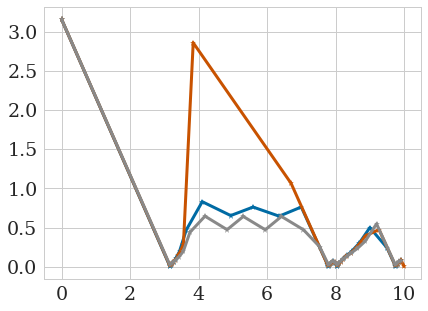

In [12]:
#plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
#plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    #plt.plot([len(clt) for clt in history])
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




#plt.legend()
#plt.xlabel('Time in hours')
#plt.ylabel('$\Delta t$ in hours')
#plt.ylim([-0.1, 1.2])
#plt.savefig('adaptivity_local_compression_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

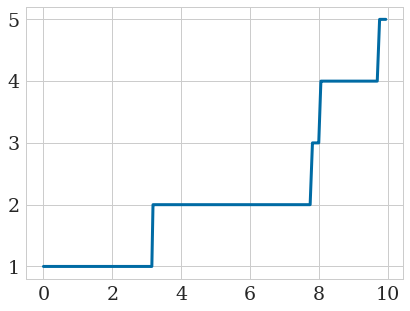

In [10]:
plt.plot(ts, [len(clt) for clt in history])

In [11]:
ts

[0.0,
 3.1500000000000004,
 3.1834768408957506,
 3.2201877838244664,
 3.2699473448498093,
 3.336551793104828,
 3.426459064639417,
 3.5524537862119874,
 3.7475104213542525,
 4.187007746412935,
 4.832456038473861,
 5.305823561589345,
 5.947596386068454,
 6.41983877667983,
 7.061687096226087,
 7.533952734718937,
 7.75,
 7.817035098635913,
 7.856390130505001,
 7.910197184030118,
 7.9823360293203836,
 8.0,
 8.062154095445896,
 8.098241144044952,
 8.151331189903555,
 8.22501451860618,
 8.324238167641843,
 8.456666242238338,
 8.63303016200672,
 8.865668081345502,
 9.192426971825027,
 9.700000000000001,
 9.76819395405328,
 9.804800340468914,
 9.854976339078798,
 9.922173053376763,
 9.950000000000001]

In [12]:
len(dts)

40

Nothing to delete.
Initial step cubic 1.5
Stability bound estimate cubic 0.06622615563204506
Nothing to delete.
Initial step pw. quad. 1.5
Stability bound estimate pw. quad. 0.07500322277704297
Nothing to delete.
Initial step GLS 1.5
Stability bound estimate GLS 0.04184717958942914


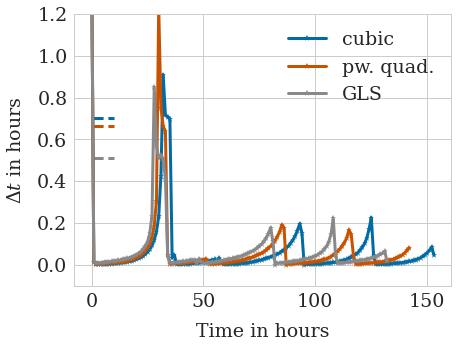

In [13]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot( dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [14]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


## Using the Jacobian to obtain the stability bound

In [15]:
dts = np.loadtxt('step_sizes_pwq.txt')

In [16]:
dts

array([1.50000000e+00, 1.51659836e-02, 5.35970596e-03, 5.79111786e-03,
       6.27031427e-03, 6.80413054e-03, 7.40061652e-03, 8.06929797e-03,
       8.82150492e-03, 9.67078743e-03, 1.06334462e-02, 1.17292159e-02,
       1.29821534e-02, 1.44218064e-02, 1.60847674e-02, 1.80167718e-02,
       2.02755736e-02, 2.29349624e-02, 2.60904966e-02, 2.98679008e-02,
       3.44357563e-02, 4.00254185e-02, 4.69637602e-02, 5.57301563e-02,
       6.70629126e-02, 8.21764700e-02, 1.03258576e-01, 1.34801925e-01,
       1.88128977e-01, 3.05175026e-01, 1.23132238e+00, 7.52303312e-01,
       6.63464788e-01, 6.38759985e-01, 4.72470658e-02, 5.65531281e-03,
       6.13308815e-03, 6.66606822e-03, 7.26256729e-03, 7.93245520e-03,
       8.68751064e-03, 9.54187019e-03, 1.05126040e-02, 1.16204607e-02,
       1.28864296e-02, 1.43377393e-02, 1.60171198e-02, 1.79730474e-02,
       2.02678757e-02, 2.29832244e-02, 2.42755608e-02, 2.98226928e-02,
       1.49171775e-02, 5.28064147e-03, 5.73508694e-03, 6.25040540e-03,
      

/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w[0])
/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w[0])
/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w[0])


Text(0, 0.5, '$\\Delta t$ in hours')

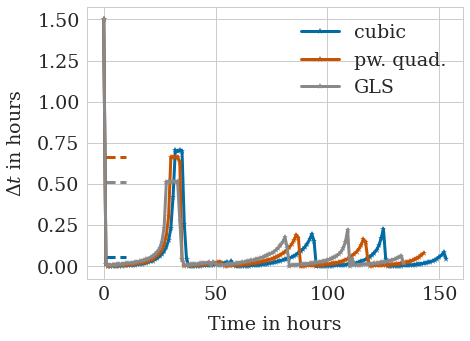

In [17]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('EVs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(dts[:, 0],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
